# Import libraries

In [ ]:
import pandas as pd
import json
from collections import defaultdict
from bs4 import BeautifulSoup
import requests
import os
import re
from collections import Counter
from functools import reduce
from tqdm.notebook import tqdm
from functools import reduce
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import heapq
from itertools import product
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem import *
import ipywidgets as widgets
from IPython.display import display, Markdown

# Import custom functions

#### Here are the function that had to be stored in a `.py` file :
#### > crawler : extract pages from the web

#### > parser: retrives information we're interested in from the extracted pages

#### > engine: allows to match queries with related documents, from the ones exctracted

In [ ]:
import custom_functions

# Import functions

#### In `functions.py` there's a series of functions that we have used to perform the tasks. This choice was made to enhance readability

In [ ]:
import functions

# 1 Data collection

## [1.1] Get the list of master's degree courses

#### We create a .txt file (msc_urls.txt) whose single line corresponds to the master's URL.

In [ ]:
# Output file path
output_file_path = 'msc_urls.txt'
# Loop through the first 400 pages and write results to the output file
with open(output_file_path, 'a') as output_file:
    for page_number in range(1, 401):
        page_url = f'https://www.findamasters.com/masters-degrees/msc-degrees/?PG={page_number}'
        page_results = functions.extract_masters(page_url)
        for url in page_results:
            output_file.write(f'{url}\n')
        time.sleep(1)

#### Each page has 15 courses, so you will end up with 6000 unique master's degree URLs. Let's check it!

In [ ]:
with open(output_file_path, 'r') as file:
    lines = file.readlines()
    number_of_lines = len(lines)

print(f'The file {output_file_path} contains {number_of_lines} rows.')

The file msc_urls.txt contains 6000 rows.


## [1.2] Crawl master's degree pages

In [ ]:
# Function to create a directory if it doesn't exist
def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

# Main directory for downloaded HTML files
main_directory = 'downloaded_pages'
create_directory(main_directory)

# Iterate through the URLs and download the HTML
with open('msc_urls.txt', 'r') as file:
    for index, url in enumerate(file, start=1):
        # Remove whitespaces and newline characters from the URL
        url = url.strip()

        # Generate the directory path for the current page
        page_directory = os.path.join(main_directory, f'page_{(index - 1) // 15 + 1}')
        create_directory(page_directory)

        # Generate the output HTML file path
        output_path = os.path.join(page_directory, f'course_{index}.html')

        # Download the HTML and save it to the file
        custom_functions.crawler(url, output_path)
        time.sleep(3)

print("Download complete for all pages.")

Download complete for all pages.


#### Now we have a folder named 'downloaded_pages' divided into 400 folders (one for each page), and each folder contains the HTML of the 15 courses present on that page.

## [1.3] Parse downloaded pages


#### We check that the parser work correctly buy testing on the first page.

#### Everything seem to work properly. Congratulations!

In [ ]:
custom_functions.parser('downloaded_pages/page_1/course_1.html')

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,administration,country,url
0,3D Design for Virtual Environments - MSc,Glasgow Caledonian University,School of Engineering and Built Environment,Full time,3D visualisation and animation play a role in ...,September,Please see the university website for further ...,MSc,1 year full-time,Glasgow,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...


## Applying the function to our html pages

#### We know collected the information from the all documents (html pages)

In [ ]:
concatenated_df=functions.parse_html('downloaded_pages')

Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_118/course_1765.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_119/course_1772.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_128/course_1910.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_140/course_2086.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_196/course_2929.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_196/course_2931.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_215/course_3213.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_291/course_4357.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_293/course_4395.html
Error parsing file: /content/drive/MyDrive/HM3-ADM/HW3_ADM/downloaded_pages/page_2

#### Note: We encounter Error parsing file each time perser function cannot perform properly

In [ ]:
# Display the concatenated DataFrame
concatenated_df.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,administration,country,url
0,3D Design for Virtual Environments - MSc,Glasgow Caledonian University,School of Engineering and Built Environment,Full time,3D visualisation and animation play a role in ...,September,Please see the university website for further ...,MSc,1 year full-time,Glasgow,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
1,Air Quality Solutions - MSc,University of Leeds,Institute for Transport Studies,Full time,Up to 7 million people are estimated to die ev...,September,"UK: £12,500 (Total) \nInternational: £28,750 (...",MSc,"1 year full time, 2 or 3 years part-time",Leeds,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2,Analytical Toxicology MSc,King’s College London,Faculty of Life Sciences & Medicine,Full time,The Analytical Toxicology MSc is a unique stud...,See Course,Please see the university website for further ...,MSc,Full-time: One year,London,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
3,Applied Computer Science and Artificial Inte...,University of Bradford,Faculty of Engineering & Digital Technologies,Full time,Computer science is the foundation of many exc...,"September, January",Please see the university website for further ...,MSc,1 Year Full Time / 2 Years Part Time,Bradford,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
4,Applied Economics (Banking and Financial Mar...,University of Bath,University of Bath Online,Part time,From political uncertainty to finance and recr...,"September, January",Cost per 10 credits £722* (10% alumni discount...,MSc,2 years and 6 months full time,Bath,Online,United Kingdom,https://www.findamasters.com/masters-degrees/c...


We can check some basic properties of our dataset such as shape and type object.

In [ ]:
concatenated_df.shape

(5979, 13)

In [ ]:
print(6000-5979, 'were not valid pages')

21 were not valid pages


#### are all stored with the format `object`

In [ ]:
parsed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   courseName      1 non-null      object
 1   universityName  1 non-null      object
 2   facultyName     1 non-null      object
 3   isItFullTime    1 non-null      object
 4   description     1 non-null      object
 5   startDate       1 non-null      object
 6   fees            1 non-null      object
 7   modality        1 non-null      object
 8   duration        1 non-null      object
 9   city            1 non-null      object
 10  administration  1 non-null      object
 11  country         1 non-null      object
 12  url             1 non-null      object
dtypes: object(13)
memory usage: 232.0+ bytes


#### We are probably happy with this up to now. As we don't want to run the parser each and every time we want to use the dataset or retrieve some more complex information we can store it.

#### In this case we save it as tsv file under the name `MasterDegrees.tsv`

In [ ]:
# Specify the path where you want to save the .tsv file
tsv_file_path = 'MasterDegrees.tsv'

# Save the DataFrame to a .tsv file
concatenated_df.to_csv(tsv_file_path, sep='\t', index=False)

### *Saving singularly the information about each master (html page)*

In [ ]:
# Iterate through each DataFrame in the list
for index, parsed_df in enumerate(parsed_dfs):
    # Iterate through each row in the DataFrame
    for row_index, row in parsed_df.iterrows():
        # Replace NaN values with empty strings
        single_row = row.fillna(' ')
        # Specify the path where you want to save the .tsv file for the current row
        tsv_file_path = f'Courses/course_{index}.tsv'
        # Save the single row DataFrame to a .tsv file
        with open(tsv_file_path, 'w') as file:
            file.write('\t'.join(single_row))

# [2.0]

## Preproccessing

#### Uploading the file created after parsing operations

In [ ]:
df = pd.read_csv('MasterDegrees.tsv',sep='\t')
df.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,administration,country,url
0,Air Quality Solutions - MSc,University of Leeds,Institute for Transport Studies,Full time,Up to 7 million people are estimated to die ev...,September,"UK: £12,500 (Total) \nInternational: £28,750 (...",MSc,"1 year full time, 2 or 3 years part-time",Leeds,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
1,Analytical Toxicology MSc,King’s College London,Faculty of Life Sciences & Medicine,Full time,The Analytical Toxicology MSc is a unique stud...,See Course,Please see the university website for further ...,MSc,Full-time: One year,London,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2,Applied Computer Science and Artificial Inte...,University of Bradford,Faculty of Engineering & Digital Technologies,Full time,Computer science is the foundation of many exc...,"September, January",Please see the university website for further ...,MSc,1 Year Full Time / 2 Years Part Time,Bradford,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
3,Applied Economics (Banking and Financial Mar...,University of Bath,University of Bath Online,Part time,From political uncertainty to finance and recr...,"September, January",Cost per 10 credits £722* (10% alumni discount...,MSc,2 years and 6 months full time,Bath,Online,United Kingdom,https://www.findamasters.com/masters-degrees/c...
4,Applied Linguistics - MSc,University of Glasgow,College of Arts & Humanities,Full time,This Masters focuses on how linguistic researc...,September,Please see the university website for further ...,MSc,1 year full-time; 2 years part-time,Glasgow,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...


## [2.0.0]

#### We process text information especially for the column `description`. We lower, stem and remove punctuation. This will be extremly useful when creating a vocabulary.

In [ ]:
# Download the stopwords dataset if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

### Stemming

In [ ]:
# Make a copy of the original DataFrame
processed_df = df.copy()

# stemmer
stemmer = PorterStemmer()

processed_df['description'] = processed_df.description.apply(lambda row: ' '.join([stemmer.stem(word) for word in row.split(' ')]))

### Lower, removing punctuation and stepwords

In [ ]:
stop_words = set(stopwords.words('english'))

# Selecting columns
text_columns = processed_df.select_dtypes(include='object').columns
# Lower
processed_df[text_columns] = processed_df[text_columns].apply(lambda x: x.str.lower() if x.dtype == 'O' else x)

# Exclude fees from removing punctuation
exclude_column = 'fees'

# Applying clean function to all the valid columns except the excluded one
processed_df[text_columns.difference([exclude_column])] = processed_df[text_columns.difference([exclude_column])].applymap(functions.clean)

#### We verify which elements were already considered in string.punctuation. Indeed checking buy some outuput of the stemmed words, we see some additional punctuation we don't want to consider, which we added within the clean function.

In [ ]:
string.punctuation

#### We can know appreciate the differences of the two datasets (before and after preprocessing). Of our interest will be the columns **fees** and **description**.

In [ ]:
processed_df.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,administration,country,url
0,air quality solutions msc,university leeds,institute transport studies,full time,7 million peopl estim die everi year due harm ...,september,"uk: £12,500 (total) \ninternational: £28,750 (...",msc,1 year full time 2 3 years part-time,leeds,campus,united kingdom,https //www.findamasters.com/masters-degrees/c...
1,analytical toxicology msc,king college london,faculty life sciences medicine,full time,analyt toxicolog msc uniqu studi cours integr ...,see course,please see the university website for further ...,msc,full-time one year,london,campus,united kingdom,https //www.findamasters.com/masters-degrees/c...
2,applied computer science artificial intelligen...,university bradford,faculty engineering digital technologies,full time,comput scienc foundat mani excit cutting-edg t...,september january,please see the university website for further ...,msc,1 year full time 2 years part time,bradford,campus,united kingdom,https //www.findamasters.com/masters-degrees/c...
3,applied economics banking financial markets on...,university bath,university bath online,part time,polit uncertainti financ recruit demands econo...,september january,cost per 10 credits £722* (10% alumni discount...,msc,2 years 6 months full time,bath,online,united kingdom,https //www.findamasters.com/masters-degrees/c...
4,applied linguistics msc,university glasgow,college arts humanities,full time,thi master focus linguist research help solv l...,september,please see the university website for further ...,msc,1 year full-time 2 years part-time,glasgow,campus,united kingdom,https //www.findamasters.com/masters-degrees/c...


### [2.0.1]

 ## We want the field fees to collect numeric information


#### We consider only *fees* column and deepen what we find

In [ ]:
raw_fees= pd.DataFrame(processed_df['fees'])

In [ ]:
raw_fees.head()

,fees
0,"uk: £12,500 (total) \ninternational: £28,750 (..."
1,please see the university website for further ...
2,please see the university website for further ...
3,cost per 10 credits £722* (10% alumni discount...
4,please see the university website for further ...


#### There are lot of missings data or more complex information we need to filter. To filter we follow the given guidline:

>    Really missing data (empty strings -122 of them), and something like this:

>>    please see the university website for further information on fees for this course.

#### We decide to set this values to `none`


In [ ]:
# Missing values for fees
print(sum(raw_fees['fees'].isna()==True))

122



> As asked, in case of multiple information, we retrieve only the highest fee. This suits perfectly the following example
>>*'uk £13,000 total international £29,000 total',
       '*

### Processing fees

We store the rates in a file. As we need to have an update versions of the rates we request the current rates to a website providing.

In [ ]:
# Your ExchangeRate-API key
api_key = '40f223580924eaf7a1eb4ee0'

# Fetch exchange rates from the API for all currencies against USD
api_url = f'https://open.er-api.com/v6/latest/USD?apikey={api_key}'
response = requests.get(api_url)
data = response.json()
exchange_rates = data['rates']

# Define a mapping between currency symbols in your data and API symbols
currency_symbol_mapping = {
    '£': 'GBP',
    '€': 'EUR',
    '$': 'USD',
    '¥': 'JPY',
    'sek':'SEK', #swedish corona
    'euro':'EUR',
    'hkn' : 'HNK',
    'euros': 'EUR',
    'jpy': 'JPY',
    'hkd':'HDK',
    'isk':'ISK',
    'hkd$': 'HKD',
    'gbp£': 'GBP'
}

pattern = r'(?P<symbol_before>[£$€¥]|euros|eur|jpy|sek|euro|hkn|hkd|isk|hkd$|gbp£)?\s*(?P<value>\d{1,3}(?:,\d{3})*)\s*(?P<symbol_after>[£$€¥]|euros|jpy|sek|euro|hkn|hkd|isk|hkd$|gbp£)?'


#### Apply the function which convert into a target value all entries of fees column

In [ ]:
text_columns = processed_df.select_dtypes(include='object').columns
# Return the list of currency symbols and costs encountered in 'fees' field through CONVERT TO COMMON CURRENCY function
raw_fees['fees (USD)'] = raw_fees['fees'].apply(lambda x: functions.return_cost(x) if x is not None else None)


`original` information and `filtered fees`

In [ ]:
raw_fees.head()

,fees,fees (USD)
0,"uk: £12,500 (total) \ninternational: £28,750 (...",35935.84
1,please see the university website for further ...,NaN
2,please see the university website for further ...,NaN
3,cost per 10 credits £722* (10% alumni discount...,902.46
4,please see the university website for further ...,NaN


In [ ]:
len(raw_fees[~raw_fees['fees (USD)'].isna()])

1345

#### Substituing and renaming the new column with the appropriate currance values

In [ ]:
processed_df['fees']= raw_fees['fees (USD)']
processed_df.rename(columns={'fees': 'fees (USD)'}, inplace=True)

#### Creating a new dataframe with the origianal variables but the new fees column

In [ ]:
fees_df = df.copy()
raw_fees= pd.DataFrame(fees_df['fees'])

In [ ]:
# Specify the path where you want to save the .tsv file
tsv_file_path = 'FilteredFees_DFD.tsv'

# Save the DataFrame to a .tsv file
fees_df.to_csv(tsv_file_path, sep='\t', index=False)

## [2.1] Conjunctive query

### [2.1.1] Create your index!

### Create a file named vocabulary, that maps each word to an integer (id).

#### First of all , let's tokenize the description to have all the words. The 'description' column in the DataFrame 'processed_df' will contain tokenized versions of the text data from the original 'description' column.

In [ ]:
processed_df['description']= processed_df.description.apply(lambda row: word_tokenize(row))

In [ ]:
processed_df.description.head()

0    [7, million, peopl, estim, die, everi, year, d...
1    [analyt, toxicolog, msc, uniqu, studi, cours, ...
2    [comput, scienc, foundat, mani, excit, cutting...
3    [polit, uncertainti, financ, recruit, demands,...
4    [thi, master, focus, linguist, research, help,...
Name: description, dtype: object

In [ ]:
vocabulary = set()
processed_df.description.apply(lambda row: [vocabulary.add(word) for word in row])

#### Now the set vocabulary contains all the words.

 #### Now we can assign unique ID to each term in the vocabulary. We create a df called vocabulary_df with 2 columns: Word and Id

In [ ]:
vocabulary_list = list(vocabulary)
vocabulary_dict = {word: index for index, word in enumerate(vocabulary_list)}
vocabulary_df=pd.DataFrame(list(vocabulary_dict.items()), columns=['Word', 'Id'])
print(vocabulary_df.head())

        Word  Id
0     retail   0
1       ntnu   1
2  macedonia   2
3       used   3
4        thi   4


#### Now we can save it , we choosed to save it both in a json and in a csv

In [ ]:
vocabulary_df.to_csv('vocabulary.csv', index=False, header=False)
#remove header to keep the name of the columns

In [ ]:
# Store in a json like a pandas dataframe
vocabulary_df.to_json('vocabulary.json', orient='records')

In [ ]:
# Write the dictionary to the JSON file directly
with open('vocabulary.json', 'w') as jsonfile:
    json.dump(vocabulary_dict, jsonfile)

#### Now let's create another dataframe called 'vocabulary_reverse' which, in addition to the columns from 'vocabulary', includes an extra column named 'reverse', containing the list of documents where that word is present

In [ ]:
vocabulary_reverse = vocabulary_df.copy()
print(vocabulary_reverse.head())

        Word  Id
0     retail   0
1       ntnu   1
2  macedonia   2
3       used   3
4        thi   4


In [ ]:
tqdm.pandas()
vocabulary_reverse['reverse'] = vocabulary_reverse.Word.progress_apply(lambda item: list(processed_df.loc[processed_df.description.apply(lambda row: item in row)].index))

100%|██████████| 12548/12548 [02:04<00:00, 100.92it/s]


In [ ]:
vocabulary_reverse.head()

,Word,Id,reverse
0,retail,0,"[213, 996, 1020, 1120, 1276, 1288, 1564, 2314,..."
1,ntnu,1,[2272]
2,macedonia,2,[506]
3,used,3,"[137, 446, 447, 1288, 1617, 2179, 3153, 3422, ..."
4,thi,4,"[1, 2, 4, 5, 9, 11, 16, 17, 18, 19, 21, 24, 26..."


In [ ]:
vocabulary_reverse[vocabulary_reverse['reverse'].apply(lambda x: len(x) == 0)]

,Word,Id,reverse


#### But Inverted Index has to be a dictionary so:

In [ ]:
inverted_index = vocabulary_reverse.set_index('Id')['reverse'].to_dict()
count = 0
for key, value in inverted_index.items():
    if count < 4:
        print(f"Key: {key}, Value: {value}")
        count += 1
    else:
        break

Key: 0, Value: [213, 996, 1020, 1120, 1276, 1288, 1564, 2314, 2346, 2374, 2564, 2570, 2571, 2752, 2894, 3581, 3730, 3890, 4021, 4032, 4210, 4317, 4724, 4725, 5873]
Key: 1, Value: [2272]
Key: 2, Value: [506]
Key: 3, Value: [137, 446, 447, 1288, 1617, 2179, 3153, 3422, 5348, 5774]


#### Since you do not want to compute the inverted index every time you use the Search Engine, it is worth thinking about storing it in a separate file and loading it in memory when needed.

In [ ]:
with open('inverted_index.json', 'w') as file:
    json.dump(inverted_index, file)

### [2.1.2] Execute the query

 We return documents which should contain ALL the words in the query

#### Selecting only the rows we need to return as output

In [ ]:
df_query = df[['courseName','universityName','description','url']].copy()
df_query.head()

,courseName,universityName,description,url
0,Air Quality Solutions - MSc,University of Leeds,Up to 7 million people are estimated to die ev...,https://www.findamasters.com/masters-degrees/c...
1,Analytical Toxicology MSc,King’s College London,The Analytical Toxicology MSc is a unique stud...,https://www.findamasters.com/masters-degrees/c...
2,Applied Computer Science and Artificial Inte...,University of Bradford,Computer science is the foundation of many exc...,https://www.findamasters.com/masters-degrees/c...
3,Applied Economics (Banking and Financial Mar...,University of Bath,From political uncertainty to finance and recr...,https://www.findamasters.com/masters-degrees/c...
4,Applied Linguistics - MSc,University of Glasgow,This Masters focuses on how linguistic researc...,https://www.findamasters.com/masters-degrees/c...


#### extracting documents for a specific query using the function engine

In [ ]:
custom_functions.engine('advance knowledge')

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,administration,country,url
1,Analytical Toxicology MSc,King’s College London,Faculty of Life Sciences & Medicine,Full time,The Analytical Toxicology MSc is a unique stud...,See Course,Please see the university website for further ...,MSc,Full-time: One year,London,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
5,Accounting and Finance - MSc,University of Leeds,Leeds University Business School,Full time,Businesses and governments rely on sound finan...,September,"UK: £18,000 (Total) \nInternational: £34,750 (...",MSc,1 year full time,Leeds,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
8,Addictions MSc,King’s College London,"Institute of Psychiatry, Psychology and Neuros...",Full time,Join us for an online session for prospective ...,September,Please see the university website for further ...,MSc,One year FT,London,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2056,Engineering with Management - MSc,University of Bristol,Faculty of Engineering,Full time,The MSc in Engineering with Management is desi...,September,Please see the university website for further ...,MSc,1 year full-time,Bristol,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2069,Enhanced Radiotherapy and Oncology Practice ...,Sheffield Hallam University,Postgraduate Courses,Part time,Enhance your knowledge of specific radiotherap...,"September, January",For part-time study the fee will be calculated...,MSc,3 years part time distance learning,Sheffield,Online,United Kingdom,https://www.findamasters.com/masters-degrees/c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024,Engineering Management (MSc),University of Gloucestershire,School of Computing and Engineering,Full time,This course will equip you with the necessary ...,September,Please see the university website for further ...,MSc,See website for details,Gloucester,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2032,Engineering Management MSc,University of Bradford,Faculty of Engineering & Digital Technologies,Full time,The MSc Engineering Management programme will ...,"September, January",Please see the university website for further ...,MSc,1 year Full time,Bradford,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2034,Engineering Management MSc,Middlesex University,Faculty of Science and Technology,Full time,The career of an engineering project manager i...,October,"UK students \nFull-time students: £10,500 \nPa...",MSc,1 year full-time; 2 years part-time,London,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
4083,M2 Research in Management and Innovation,Université Côte d’Azur,UCA International MSc Program,Full time,"Our modern industry structures, value chains a...",September,The tuition currently stands at €243 as well a...,MSc,2 years,Nice,On Campus,France,https://www.findamasters.com/masters-degrees/c...


## [2.2] Conjunctive query & Ranking score

### [2.2.1] Inverted index

### For each word, you want the list of documents in which it is contained and the relative tfIdf score.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#### The following code computes TF-IDF values for the text in the 'description' column and stores the TF-IDF matrix in the DataFrame tfidf_data, where each row corresponds to a document, each column corresponds to a word, and the values represent TF-IDF scores.

In [ ]:
tfidf = TfidfVectorizer(input='content', lowercase=False, tokenizer=lambda text: text) # , max_df=0.1
results = tfidf.fit_transform(processed_df['description'])
result_dense = results.todense()
tfidf_data = pd.DataFrame(result_dense.tolist(), index=processed_df.index, columns=tfidf.get_feature_names_out())

#### Creating a dictionary in the format Word:[(document1, tfIdf_{term,document1}), (document2, tfIdf_{term,document2})...

In [ ]:
inverted_index_2 = {}
for word in tfidf_data.columns:
    word_docs = tfidf_data.index[tfidf_data[word] > 0].tolist()
    word_doc_scores = [(doc, tfidf_data.loc[doc, word]) for doc in word_docs]
    inverted_index_2[word] = word_doc_scores

In [ ]:
count = 0
for word, doc_scores in inverted_index_2.items():
    print(f"Word: {word}")
    print("Document Scores:")
    print(doc_scores)
    count += 1
    if count == 10:
        break

Word: 'all
Document Scores:
[(3871, 0.1849258796135223)]
Word: 'appli
Document Scores:
[(2325, 0.1722113554646612)]
Word: 'bench
Document Scores:
[(333, 0.3466489203597607)]
Word: 'big
Document Scores:
[(1217, 0.2404462962515215), (1225, 0.1886881267487287), (1290, 0.2107926430819876), (5692, 0.17695012088105525)]
Word: 'chip
Document Scores:
[(1902, 0.1992739368962018)]
Word: 'credits
Document Scores:
[(2317, 0.18303193893688977), (5926, 0.08382342995897132)]
Word: 'd
Document Scores:
[(2160, 0.194367236072988), (4863, 0.14435725548964343)]
Word: 'disability
Document Scores:
[(4783, 0.17222181095019545)]
Word: 'educ
Document Scores:
[(2618, 0.2647135148766833)]
Word: 'entri
Document Scores:
[(641, 0.20952396586542038)]


#### But we need to have the word's ID as the key, not the word itself, we can take this ID from the vocabulary_df. We'll create a new dictionary that meets the requirements specified in the prompt.

In [ ]:
new_inverted_index = {}
for word, doc_scores in inverted_index_2.items():
    word_id = vocabulary_df[vocabulary_df['Word'] == word]['Id'].values
    if len(word_id) > 0:
        word_id = word_id[0]
        new_inverted_index[word_id] = doc_scores

#### Let's see the result

In [ ]:
n = 10

partial_inverted_index = {k: new_inverted_index[k] for k in list(new_inverted_index.keys())[:n]}
print(partial_inverted_index)

{7237: [(3871, 0.1849258796135223)], 8785: [(2325, 0.1722113554646612)], 9700: [(333, 0.3466489203597607)], 3365: [(1217, 0.2404462962515215), (1225, 0.1886881267487287), (1290, 0.2107926430819876), (5692, 0.17695012088105525)], 1201: [(1902, 0.1992739368962018)], 650: [(2317, 0.18303193893688977), (5926, 0.08382342995897132)], 11512: [(2160, 0.194367236072988), (4863, 0.14435725548964343)], 7980: [(4783, 0.17222181095019545)], 2565: [(2618, 0.2647135148766833)], 4168: [(641, 0.20952396586542038)]}


#### Compare document with cosine similarity

Given a query we will compare the query and evaluate the cosine similarity between th query and the extracted document through the engine function. We retrieve k = 10 documents: the first k ordered by cosine similarity.

In [ ]:
df_query_processed= processed_df[['courseName','universityName','description','url']].copy()

In [ ]:
tfidf = TfidfVectorizer(input='content', lowercase=False, tokenizer=lambda text: text) # , max_df=0.1
results = tfidf.fit_transform(df_query_processed['description'])
result_dense = results.todense()
tfidf_data = pd.DataFrame(result_dense.tolist(), index=df_query_processed.index, columns=tfidf.get_feature_names_out())

In [ ]:
print(tfidf_data.head())

   'all  'appli  'bench  'big  'chip  'credits   'd  'disability  'educ  \
0   0.0     0.0     0.0   0.0    0.0       0.0  0.0          0.0    0.0   
1   0.0     0.0     0.0   0.0    0.0       0.0  0.0          0.0    0.0   
2   0.0     0.0     0.0   0.0    0.0       0.0  0.0          0.0    0.0   
3   0.0     0.0     0.0   0.0    0.0       0.0  0.0          0.0    0.0   
4   0.0     0.0     0.0   0.0    0.0       0.0  0.0          0.0    0.0   

   'entri  ...  ﻿over  ﻿prove  ﻿regist  ﻿th  ﻿the  ﻿theoret  ﻿thi  ﻿want   ﻿y  \
0     0.0  ...    0.0     0.0      0.0  0.0   0.0       0.0   0.0    0.0  0.0   
1     0.0  ...    0.0     0.0      0.0  0.0   0.0       0.0   0.0    0.0  0.0   
2     0.0  ...    0.0     0.0      0.0  0.0   0.0       0.0   0.0    0.0  0.0   
3     0.0  ...    0.0     0.0      0.0  0.0   0.0       0.0   0.0    0.0  0.0   
4     0.0  ...    0.0     0.0      0.0  0.0   0.0       0.0   0.0    0.0  0.0   

    ﻿﻿  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  

[5 rows

#### We defined a function rank_documents which is available on functions.py.

Copules of `EXAMPLES` were we leverage the function rank_documents to accomplished the mentioned task

In [ ]:
functions.rank_documents("advanced knowledge")

,courseName,universityName,description,url,Similarity
1,Analytical Toxicology MSc,King’s College London,The Analytical Toxicology MSc is a unique stud...,https://www.findamasters.com/masters-degrees/c...,1.0
8,Addictions MSc,King’s College London,Join us for an online session for prospective ...,https://www.findamasters.com/masters-degrees/c...,1.0
2056,Engineering with Management - MSc,University of Bristol,The MSc in Engineering with Management is desi...,https://www.findamasters.com/masters-degrees/c...,1.0
2073,Enterprise Management MSc/PGDip,University College Birmingham,In today’s increasingly competitive business e...,https://www.findamasters.com/masters-degrees/c...,1.0
2089,Entrepreneurship and Innovation Management MSc,University of Exeter,Overview\nGain a fully transferable and implem...,https://www.findamasters.com/masters-degrees/c...,1.0
2044,Engineering Materials (Advanced Mechanical E...,University of Southampton,Develop specialist knowledge of mechanical eng...,https://www.findamasters.com/masters-degrees/c...,1.0
4169,Accounting and Finance - MSc,University of Sussex,On this MSc you’ll advance your accounting and...,https://www.findamasters.com/masters-degrees/c...,1.0
4180,Management and Digital Business (with Advanc...,Liverpool John Moores University,This Advanced Practice course provides an in-d...,https://www.findamasters.com/masters-degrees/c...,1.0
4203,Management in Construction (MSc),Kingston University,This industry-accredited course is suitable fo...,https://www.findamasters.com/masters-degrees/c...,1.0
115,Bioscience (MSc),KAUST,The Bioscience (B) program plays a key role in...,https://www.findamasters.com/masters-degrees/c...,1.0


In [ ]:
functions.rank_documents("air pollution")

,courseName,universityName,description,url,Similarity
5430,Air Pollution Management and Control - MSc/P...,University of Birmingham,Our Air Pollution Management and Control MSc i...,https://www.findamasters.com/masters-degrees/c...,0.99589
0,Air Quality Solutions - MSc,University of Leeds,Up to 7 million people are estimated to die ev...,https://www.findamasters.com/masters-degrees/c...,0.98058
2128,Environmental Analytical Chemistry - MSc,University of Bristol,"Climate change, and air, water and soil pollut...",https://www.findamasters.com/masters-degrees/c...,0.98058
2150,Environmental Engineering - MSc,Imperial College London,This course provides training in all aspects o...,https://www.findamasters.com/masters-degrees/c...,0.94868
2216,Environmental Pollution Control MSc,University of Southampton,Explore Environmental Pollution Control at a g...,https://www.findamasters.com/masters-degrees/c...,0.83205


# [3]

In [ ]:
geolocator = Nominatim(user_agent="my_user_agent")

### Define a new metric for scoring the universities

####To make the score more personal, the user (student) will be asked to input 2 new info:
- **"In which city would you prefer to study?"** It is possible to input every city in the world, and even other universities. However, the main idea is that the score will be lowered should the university be far from where the student wants to study.
- **"What is the maximum distance from the university to the city centre (in Kilometres) that you are willing to accept?"** This will set a MaxDistance from the input above. Let's say for instance that i want to study in London and be 20 Km far from the city. The metric will take into consideration that. Every university further from the specified distance will have a negative score.

We will still use the cosine similarity as our baseline, since it gives us a starting point to evaluate how similar with the query the documents are.
Secondly, the cossim will be multiplied by 2 new parametres, which will refine the metric.

The first parametre is $$(\epsilon + 1 - (\frac{UniDistance}{MaxDistance}))$$
- Unidistance is the distance from the city, entered by the user
- Max distance is the second value entered by the user
The higher the parametre, the better the result. Note that the UniDistance can be higher than the MaxDistance, so you could expect a negative score, which significantly lowers the position of the university. $\epsilon$ is a parametre added to keep the total from being zero (for example when UniDistance = MaxDistance, the result of the formula is just $\epsilon$)

The second parametre is $$(\epsilon + 1 - (\frac{UniFees}{MaxFees}))$$
- UniFees is the cost of the university, and we will use the processed fees column from the point above.
- MaxFees is the max cost among every column
$\epsilon$ is a parametre added to keep the total from being zero (for example when UniFees = MaxFees, the result of the formula is just $\epsilon$)

So the new scoring function is defined as follows: $$SimilarityScore = CosineSimilarity(Query, Document)*(\epsilon + 1 - (\frac{UniDistance}{MaxDistance}))*(\epsilon + 1 - (\frac{UniFees}{MaxFees}))$$



### IMPORTANT INFO ON PROCESSED FEES:

The number of universities with clean fees is way lower than the total.


Just to give a rough estimation $\approx1300$ out of $5979$ universities are visualized correctly, whereas the others have a "Please navigate to another page to collect the fees". To avoid a scoring problem, as well as a visualization one, the NA values are replaced with the an interpolated value. To be precise, citing Pandas documentation "Fill NaN values using an interpolation method". We choose the "linear" method, which in this case seems to preserve the distribution of fees.

It has to be kept in mind that the NOT every score is precisely the best for the student (because of the intepolated values), and giving an "outlier" fee to a specific university just because the parsing mechanism required a second step wasn't technically a correct choice.



In [ ]:
# Interpolate the missing values (na values with the linear method)
raw_fees["fees (USD)"] = raw_fees["fees (USD)"].interpolate(method = "linear")
# Fill the remaining na values with the mean, since a value was missing
raw_fees["fees (USD)"] = round(raw_fees["fees (USD)"].fillna(raw_fees["fees (USD)"].mean()),2)
max_fees = raw_fees["fees (USD)"].max() #compute the max fees

As described in the introduction, we insert our desiderata *interactivly*, as shown in the following cell. We then required the information through our new_engine

In [ ]:
ranked_universities = functions.rank_documents_advanced("advanced knowledge artificial intelligence",max_fees)

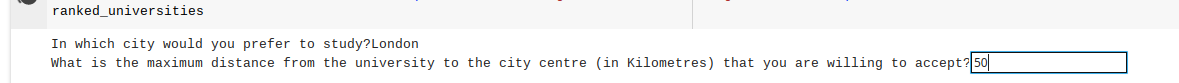

Add to the ranked_universities dataframe fees,cities and countries, for the next question

In [ ]:

ranked_universities["fees"] = raw_fees['fees (USD)']  #add fees to the dataframe
ranked_universities["country"] = df["country"] #add country to the dataframe
ranked_universities["city"] = df["city"] #add city to the dataframe


In [ ]:
ranked_universities

,courseName,universityName,description,url,Similarity,fees,country,city
4589,Master of Management in Artificial Intelligence,York University (Canada),"Looking for Coders, Innovators and AI Visionar...",https://www.findamasters.com/masters-degrees/c...,0.94668,13.66,Canada,Toronto
1913,Electronics Engineering,Linköping University,This programme focuses on the design of integr...,https://www.findamasters.com/masters-degrees/c...,0.87478,1118.90,Sweden,Linkoping
5775,Artificial Intelligence MSc,University of Huddersfield,"In the UK, we have seen a huge expansion in ar...",https://www.findamasters.com/masters-degrees/c...,-2.08603,6984.96,United Kingdom,Huddersfield
1356,Data Science with Artificial Intelligence MSc,University of Exeter,Overview\nDesigned for those interested in lea...,https://www.findamasters.com/masters-degrees/c...,-3.74225,19172.56,United Kingdom,Exeter
5749,Artificial Intelligence (MSc),Queen’s University Belfast,In the last decade the advances in Artificial ...,https://www.findamasters.com/masters-degrees/c...,-3.90118,6840.11,United Kingdom,Belfast
5774,Artificial Intelligence MSc,University of East London,This programme is designed for those who want ...,https://www.findamasters.com/masters-degrees/c...,-4.33960,9949.48,United Kingdom,London
5140,Advanced Computer Science (Artificial Intell...,University of Leeds,From software agents used in networking system...,https://www.findamasters.com/masters-degrees/c...,-9.46741,39958.32,United Kingdom,Leeds


### Performance review

The new metric works in a different way from the original, and the output can be interpreted in the following way:
- If different universities are in the same radius specified by the user, the ranking will be more precise than the original one, since the higher overall score will be destined for the universities with the highest value in each parenthesis.
- If the university is far from the specified location, its score will be lower, so is is indeed a very important metric to consider.

# [4]

### For this visualization task we used the Folium library, with the geolocator Nominatim.

- The first one gives us the OpenStreetMap with marked coordinates, colors and information about the Master courses.
- The second one let us compute the coordinates of every university, and the geodesic distance between two points (which are the city where the student wants to study and the university)

Following the same line of argument as point Q3, the student will be asked to input the city where he is most likely to study (and this will centre the map on the specified city, with a certain zoom). The map will then show the universities, sorted by color and with a legend on the top right corner:
- The greener the "Circle Marker" the less fees the student has to pay (Also take into consideration how some values of the fees have been processed in point Q3)

Note that the map is interactive, you can zoom in and out, and will show the following information if you click on a marker:
- University
- Country
- City
- Course Name
- Fees
- Distance from the user input
- The new personalized score, so that the student can evaluate every option in the map

In [ ]:
#sort ranked_universities by fees, from lowest to highest, so that the map will show the cheapest universities first.
ranked_universities = ranked_universities.sort_values(by=['fees'], ascending=True)

In [ ]:
coordinates = []
university_list = []

for element in ranked_universities.universityName:
    univ = element
    university_list.append(univ)
    # We need to offset the coordinates by a random factor so that
    # If two Msc are from the same university they are shown in the map
    loc = geolocator.geocode(univ)
    # Offest the coordinates by a random factor
    offset_univ_coordinates = (loc.latitude + np.random.uniform(10**(-3), 10**(-3.5)),
                               loc.longitude + np.random.uniform(10**(-3), 10**(-3.5)))
     # Add the coordinates to a list
    coordinates.append(offset_univ_coordinates)

In [ ]:
# Reindex ranked_universities, so that Foliun works properly
ranked_universities = ranked_universities.reset_index()

In [ ]:
# Ask the user to input the city where he/she would like to study
initial_test = input()

initial_coordinates = geolocator.geocode(initial_test) #get coordinates
initial_point = [initial_coordinates.latitude, initial_coordinates.longitude] #add the coordinates to a list


uni_map = folium.Map(location=initial_point, zoom_start=12) #specify the initial point (city) and the zoom level
# Indexing the colormap with the index of the dataframe
colormap = cm.LinearColormap(colors=["darkgreen",'green','yellow','orange',"red","darkred"],
                             index=ranked_universities.index,vmin=(min(ranked_universities.fees)),
                             vmax=max(ranked_universities.fees))
# Remove index to show the correct colormap
colormap_show = cm.LinearColormap(colors=["darkgreen",'green','yellow','orange',"red","darkred"],
                                  vmin=(min(ranked_universities.fees)),vmax=max(ranked_universities.fees))
# Add a circle to the map, with a radius of 5km (default value, but the score funcition will take into
# consideration the user input), to show the maximum distance from the city that the user is willing to accept
folium.Circle(initial_point,radius = 5000).add_to(uni_map)

for coordinate, idx in zip(coordinates,ranked_universities.index):
    html = '''
    <b>University: </b>{university}<br>
    <b>Country: </b>{country}<br>
    <b>City: </b>{city}<br>
    <b>Course Name:</b>{coursename}<br>
    <b>Fees: </b>{fees} $<br>
    <b>Distance from your specified location: </b>{distance} Km <br>
    <b>Score: </b>{newscore}

    '''.format(university=ranked_universities.universityName[idx],index=ranked_universities.fees,
               country=ranked_universities.country[idx],city=ranked_universities.city[idx],
               coursename=ranked_universities.courseName[idx],fees=ranked_universities.fees[idx],
               distance=round(distance.distance(coordinate,initial_point).km,2),
               newscore = ranked_universities.Similarity[idx])

    # Create a popup with the function Popup, which will show the information about
    #the university when clicked on the marker
    new_popup = folium.Popup(html, parse_html=False, max_width=1000)

    folium.CircleMarker(
        location=coordinate,
        fill = True,
        popup=new_popup,
        color = colormap(idx),
        fill_color = colormap(idx)
    ).add_to(uni_map)



uni_map.add_child(colormap_show)


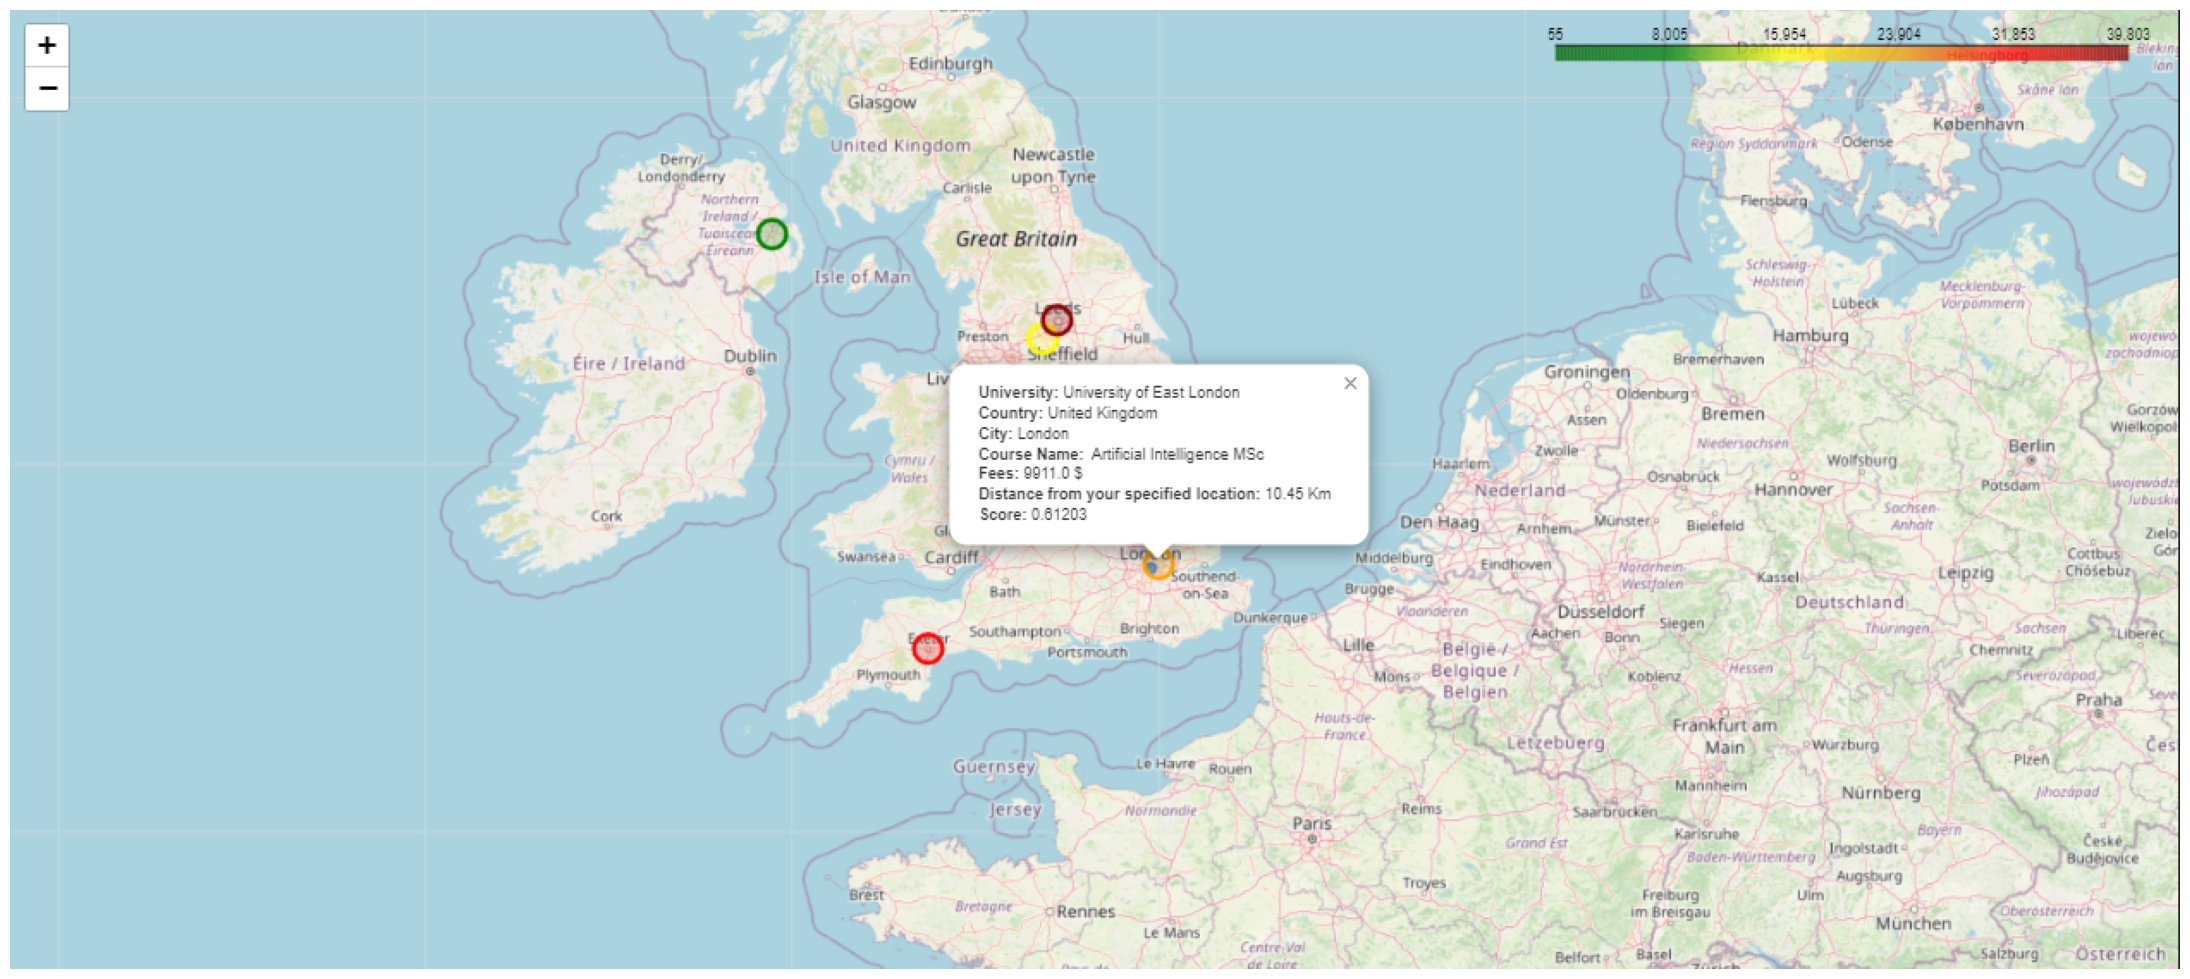

In [ ]:
file_path = 'Uni_map.png'

image = Image.open(file_path)

plt.figure(figsize=(28, 21))
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()



# [5] Bonus

We create a new engine given the possibility to specify fields of the dataset with some interactive tools

In [ ]:
df1 = pd.read_csv('FilteredFees_DFD.tsv',sep='\t')

In [ ]:
# We make a copy to retrieves all months where a course begins
df2 = df1.copy()
df2['startDate'] = df2['startDate'].astype(str).str.split(',')
df2.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees (USD),modality,duration,city,administration,country,url
0,Air Quality Solutions - MSc,University of Leeds,Institute for Transport Studies,Full time,Up to 7 million people are estimated to die ev...,[September],35949.59,MSc,"1 year full time, 2 or 3 years part-time",Leeds,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
1,Analytical Toxicology MSc,King’s College London,Faculty of Life Sciences & Medicine,Full time,The Analytical Toxicology MSc is a unique stud...,[See Course],NaN,MSc,Full-time: One year,London,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
2,Applied Computer Science and Artificial Inte...,University of Bradford,Faculty of Engineering & Digital Technologies,Full time,Computer science is the foundation of many exc...,"[September, January]",NaN,MSc,1 Year Full Time / 2 Years Part Time,Bradford,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...
3,Applied Economics (Banking and Financial Mar...,University of Bath,University of Bath Online,Part time,From political uncertainty to finance and recr...,"[September, January]",902.80,MSc,2 years and 6 months full time,Bath,Online,United Kingdom,https://www.findamasters.com/masters-degrees/c...
4,Applied Linguistics - MSc,University of Glasgow,College of Arts & Humanities,Full time,This Masters focuses on how linguistic researc...,[September],NaN,MSc,1 year full-time; 2 years part-time,Glasgow,On Campus,United Kingdom,https://www.findamasters.com/masters-degrees/c...


Through *widget* we can filter through this interface like in the following `example`:


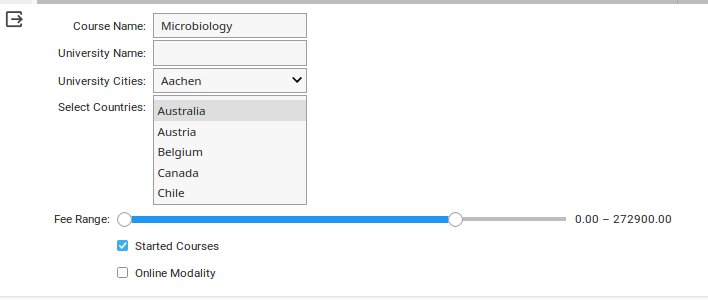

In [ ]:
# Dropdown menu widget

course_name_widget = widgets.Text(description='Course Name:')
university_name_widget = widgets.Text(description='University Name:')
cities= sorted(df1['city'].unique().tolist())
university_city_widget = widgets.Dropdown(options=['--']+cities, description='University Cities:')
country= sorted(df1['country'].unique().tolist())
university_country_widget = widgets.Dropdown(options=country, description='University Country:')

# FloatRangeSlider for fee range
fee_range_widget = widgets.FloatRangeSlider(
    min=df1[df1['fees (USD)'].notna()]['fees (USD)'].min(),
    max=df1[df1['fees (USD)'].notna()]['fees (USD)'].max(),
    step=100,
    description='Fee Range:'
)

# Selecting multiple countries
# Get unique countries from the DataFrame
all_countries= sorted(df1['country'].unique().tolist())

# Dropdown widget allowing multiple country selections
multi_select_dropdown = widgets.SelectMultiple(
    options=country,
    value=[country[0]],
    description='Select Countries:'
)

# Global variable to store selected countries
selected_countries = set()

# Dropdown widget allowing multiple country selections
multi_select_dropdown = widgets.SelectMultiple(
    options=all_countries,
    value=[all_countries[0]],
    description='Select Countries:'
)

# Function to handle widget value change
def on_multi_select_change(change):
    global selected_countries
    selected_countries.update(change.new)

    display(Markdown(f'You selected {selected_countries}'))

# Attach the function to the widget's value change event
multi_select_dropdown.observe(on_multi_select_change, names='value')

# Checkbox widgets
started_courses_widget = widgets.Checkbox(value=False, description='Started Courses')
online_modality_widget = widgets.Checkbox(value=False, description='Online Modality')


# Adjusting widget layout for better readability
course_name_widget.style.description_width = '40%'
university_name_widget.style.description_width= '40%'
university_city_widget.style.description_width= '40%'
multi_select_dropdown.style.description_width = '40%'


# Adjusting widget layout for better readability
fee_range_widget.layout.width = '50%'

# Display widgets
display(course_name_widget, university_name_widget,university_city_widget, multi_select_dropdown, fee_range_widget, started_courses_widget, online_modality_widget)


Text(value='', description='Course Name:', style=DescriptionStyle(description_width='40%'))

Text(value='', description='University Name:', style=DescriptionStyle(description_width='40%'))

Dropdown(description='University Cities:', options=('--', 'Aachen', 'Aalborg', 'Aberdeen', 'Aberystwyth', 'Abu…

SelectMultiple(description='Select Countries:', index=(0,), options=('Australia', 'Austria', 'Belgium', 'Canad…

FloatRangeSlider(value=(90956.25, 272868.75), description='Fee Range:', layout=Layout(width='50%'), max=363825…

Checkbox(value=False, description='Started Courses')

Checkbox(value=False, description='Online Modality')

### Manual

The user can select `course name`, `university name`, a `city` between those present in the dataset, as well as countries. These last two are easy to find as they were ordered.

Contries selected are shown in ouput

>**When the user want to make a new research can rerun the precedent cell**

> When there were not enought information the entire row is selected

> When there is no match then the following message is displayed: *Try a more flexible query. Your search did not produce any result*



for pratical use we create a function to store all the selectino made by the user

In [ ]:
# Variable to store selected values
def multiple_query():
  selected_course_name = course_name_widget.value
  selected_university = university_name_widget.value
  selected_city = university_city_widget.value
  selected_country = list(selected_countries)
  selected_fee_range = fee_range_widget.value
  selected_started_courses = started_courses_widget.value
  selected_online = online_modality_widget.value
  return ([selected_course_name, selected_university, selected_city, selected_country, selected_fee_range, selected_started_courses, selected_online])
q = multiple_query()
print(q)

['Microbiology', '', 'Aachen', ['Switzerland', 'Greece', 'Belgium', 'Italy'], (0.0, 272900.0), False, True]


we proceed similarly as for other engines

In [ ]:
functions.extract_multiple_query(q)

then merge the queries avoind the case of empty `courseName`

In [ ]:
# Check if either DataFrame is empty
if q[0]=='':
    # Handle the case where one of the DataFrames is empty
    union = functions.extract_multiple_query(q)
else:
    df_query_advanced = functions.rank_documents1(q[0])
    # Perform the union operation
    union = df_query_advanced.index.union(functions.rank_documents1(q[0]).index)


In [ ]:
union

Int64Index([66, 75, 76, 89, 93, 548, 593, 1002, 2204, 2574, 2598, 4461, 5607,
            5608],
           dtype='int64')

here the output of the precedent example

In [ ]:
df2.loc[union][['courseName', 'universityName','url']]

,courseName,universityName,url
66,Biomedical Science (Blended Learning) MSc,Keele University,https://www.findamasters.com/masters-degrees/c...
75,Biomedical Science (Medical Microbiology) - ...,Keele University,https://www.findamasters.com/masters-degrees/c...
76,Biomedical Science (Medical Microbiology) MS...,Middlesex University,https://www.findamasters.com/masters-degrees/c...
2574,Food Microbiology MSc,University College Cork,https://www.findamasters.com/masters-degrees/c...
593,Clinical Microbiology (Distance Learning) MS...,University of Nottingham,https://www.findamasters.com/masters-degrees/c...
89,Biomedical Sciences - Medical Microbiology MSc,University of Westminster,https://www.findamasters.com/masters-degrees/c...
2204,Environmental Microbiology and Biotechnology...,Bangor University,https://www.findamasters.com/masters-degrees/c...
93,Biomedical Sciences MSc,University of Westminster,https://www.findamasters.com/masters-degrees/c...
548,Clinical and Molecular Microbiology MSc/PGDi...,University of Nottingham,https://www.findamasters.com/masters-degrees/c...
2598,Food Science MSc,London Metropolitan University,https://www.findamasters.com/masters-degrees/c...


## How documents are aggregated

This query is very flexible and the output varies a lot depending on how specified or not is the query itself.

Indeed when no match is found a message is returned

We aggregate the document based on the following decisions:

> When the name of the course is NOT empty we make the union of the output of other filters and the cosine similarity. This retrievers a larger set of university based on the fact that the name of the course may be not addreses in the title but appears in the description and the user can be interested in that output too.

> We consider all documents in a selected city

> We consider all contries selected

> We retrieve all courses which fees is within the range or where the fees in not explicited

> We retrieve courses if Online or On Campus based on the selected modality


Basically we can consider similarity between the query and the dataset to be 1 if matches the condition and 0 otherwise and take the union or the intersection on the features.

When request are not so specialized like for example asking for a very patricolar Master Degrees in Aachen only Online (Online courses are lower in proportion that On Campus ones) the engine will match some document high related to the course name input. Moreover flexibility is achieved buy the multiple choices.

# [6] Command Line

    #!/bin/bash
    grep -i 'part-time' merged_courses.tsv |  wc -l > part_time_colleges_count.txt
    echo " Print the number of part time education "
    cat part_time_colleges_count.txt
    #----------------------
    total_courses=$(wc -l < merged_courses.tsv)
    engineering_courses=$(grep -i 'Engineer' merged_courses.tsv | wc -l)
    echo "Total Courses: $total_courses"
    echo "Engineering Courses: $engineering_courses"
    percentage=$(echo "scale=2; ($engineering_courses / $total_courses) * 100" | bc)
    echo "Percentage: $percentage"
    echo $percentage > engineering_percentage.txt
    #-----------------------------------------------------
    # Load the CSV data into a temporary table
    sqlite3 tmp.db <<EOF
    .mode csv
    .import file.csv courses
    EOF
    # Get country and city count for MS degrees
    RESULTS=$(sqlite3 tmp.db "
    SELECT administration, city, COUNT(*) AS num_ms
    FROM courses
    WHERE modality LIKE '%MSc%'
    GROUP BY administration, city
    ORDER BY num_ms DESC
    LIMIT 1;
    ")
    # Print out the top country, city for MS degrees
    echo "Country and city with the most MS degrees:"
    echo "$RESULTS"
    # Clean up temporary database
    rm tmp.db
    chmod +x analysis.sh

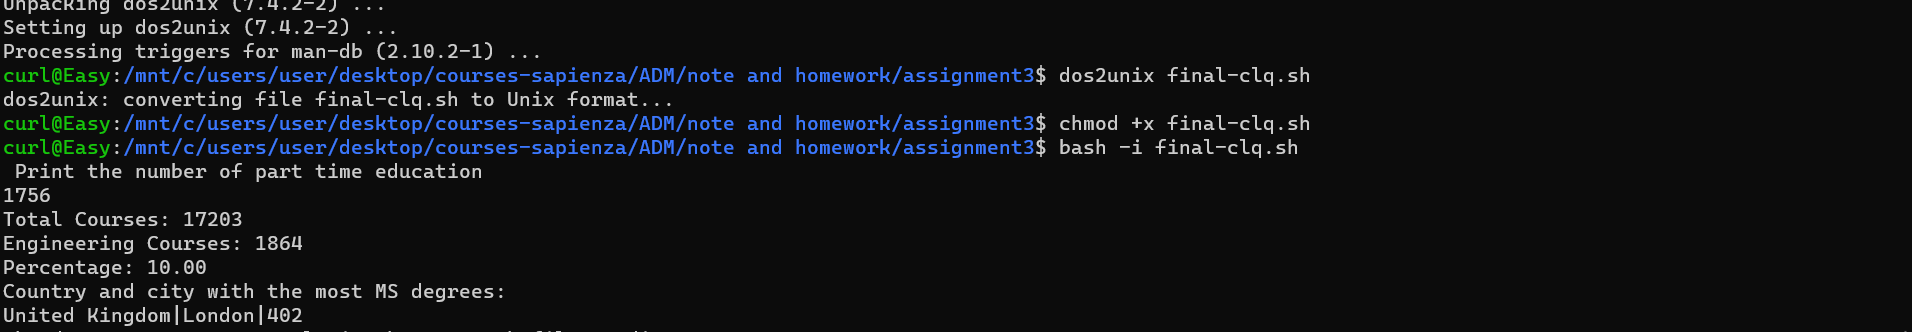

#[7] Algorithmic question

The problem involves helping Leonardo create a fake report on the number of hours he worked each day for the past d days. Leonardo has the total sum of hours he worked, the number of days, and HR limitations for each day.

## Implementation of the code

In [ ]:
# Input the total number of days and the total number of hours
total_days, sum_hours = map(int, input().split())

# Initialize a list to store the ranges of hours for each day
day_min_max = []

# Input the minimum and maximum hours for each day and create a list of ranges
for _ in range(total_days):
    min1, max1 = map(int, input().split())
    day_min_max.append([i for i in range(min1, max1 + 1)])

def find_combinations_with_sum(nested_list, target_sum):
    """
    Having a nested list with the information of the overall amount of days and hour
    worked and informationa bout mintime e maxtime for a single day, returns wether
    it it possibile to return a fake report which respect costrains
    """
    # Get the minimum and maximum hours for each day
    min_hours = [day[0] for day in day_min_max]
    max_hours = [day[-1] for day in day_min_max]

    # Check if the total hours are within the valid range
    if sum_hours >= sum(min_hours) and sum_hours <= sum(max_hours):
        print('YES')
    else:
        print('NO')

    # Iterate through all combinations of hours and print those with the target sum
    for combination in product(*nested_list):
        if sum(combination) == target_sum:
            print(*combination)

# Call the function with the provided day_min_max and sum_hours
find_combinations_with_sum(day_min_max, sum_hours)


1 1
2 3
NO



## Let's combine the time complexity of individual parts to determine the overall time complexity of the provided code:



Initializing min_hours and max_hours: O(total_days)
* Checking total hours range: O(1)
* Generating combinations: O(product of sizes of nested_list)
* Overall, the dominant factor is the third part involving the generation of combinations. Therefore, the overall time complexity is O(product of sizes of nested_list).

#### example : if we have only two working days


let's calculate the number of combinations generated by the product function for two days, each with a range of (max - min + 1) hours

day1 = max_hour - min_hour + 1 = n1

day2 = max_hour - min_hour + 1 = n2


Complexity would be : O(n1 * n2 )

## ChatGpt Implementation



both awsers are right but we think the complexity of the code that Chatgpt has been generated is better since it use backtracking algorithm which avoids generation all combination

##  **Optimality**:


The solution can be considered suboptimal in terms of time complexity, especially when the ranges for each day are large.
It generates all combinations using itertools.product, which can be inefficient for large inputs.
An improvement could be to use a backtracking algorithm that explores valid combinations more efficiently, terminating the search as soon as a valid combination is found.